# 02 Bias Exposure and Naive ATE

This notebook implements MVP 1.3 requirements: First, provide an overall ATE estimate, and then through stratified analysis reveal significant heterogeneity of treatment effects (HTE) among different subgroups, providing a business rationale for subsequent individual-level estimation in Uplift Modeling.

## Section 0: Setup

In [1]:
import os
import sys
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from IPython.display import Markdown, display
from scipy import stats

# Avoid hardcoding the project root path
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
# Add project root to sys.path to enable 'from src.xxx import' syntax.
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Change working directory to project root for consistent path resolution
os.chdir(project_root)

# Standardized plotting style
# Improves visual consistency and reviewer readability.
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 13
sns.set_palette('Set2')

# Load config
config_candidates = [project_root / 'configs' / 'config.yaml', project_root / 'configs' / 'config.yml']
config_path = next((p for p in config_candidates if p.exists()), None)
if config_path is None:
    raise FileNotFoundError(f'No config file found. Searched: {[str(p) for p in config_candidates]}')
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Load cleaned data
cleaned_data_path = config['paths']['cleaned_data']
df = pd.read_csv(cleaned_data_path)

figures_dir = Path(config['paths']['figures_dir'])
figures_dir.mkdir(parents=True, exist_ok=True)

print(f'Data loaded: shape={df.shape}')
print(f'Conversion rate: {df['conversion'].mean():.4%}')
print(f'"Treatment:Control"ratio: {df['treatment'].sum()}:{(1-df['treatment']).sum()}')
print(f'Zero spend ratio: {(df['spend']==0).mean():.2%}')


Data loaded: shape=(64000, 13)
Conversion rate: 0.9031%
"Treatment:Control"ratio: 42694:21306
Zero spend ratio: 99.10%


数据关键特征标注
- **Conversion rate ≈ 0.90%**: `conversion` 正样本率仅 0.90% (~576 个正样本),属于极端类别不平衡
- **Zero spend ratio = 99.1%**: `spend` 作为连续目标变量统计意义极低，本 Notebook 不对其计算朴素 ATE
- **Treatment:Control = 2:1** (42,694 vs 21,306): `Treatment` 组样本量充足
- **RCT data**：Hillstrom 为 RCT 数据，`Treatment` 随机分配，理论上不存在选择偏差

Section 0 summary: 因此本 Notebook 的叙事重心不是"暴露偏差"(RCT 中偏差为零)，而是"暴露异质性" — 总体 ATE 掩盖了子群体间效应幅度的巨大差异, 这正是 Uplift Modeling 存在的理由

## Section 1: Overall Naive ATE 

In [ ]:
# ===================================================
# Section 1: Overall Naive ATE Calculation
# Business Logic: Examine the global impact of treatment (email marketing)
# ===================================================

# ---------------------------------------------------
# 1.1 Calculate naive ATE for conversion
# ---------------------------------------------------
# Technical Note: In RCT, naive difference-in-means is an unbiased estimator of ATE
# due to random assignment. In observational data, selection bias would require adjustment.

treated = df[df['treatment'] == 1]
control = df[df['treatment'] == 0]

# Core business metric: conversion rate lift
conv_rate_treated = treated['conversion'].mean()
conv_rate_control = control['conversion'].mean()
ate_naive_conv = conv_rate_treated - conv_rate_control

print('='* 60)
print('Overall Naive ATE (Conversion)')
print('=' * 60)
print(f'"Treatment" conversion rate: {conv_rate_treated:.4%}')
print(f'"Control" conversion rate:   {conv_rate_control:.4%}')
print(f'     Naive ATE (abs):        {ate_naive_conv:.4%}')
print(f'      Relative Lift:         {(ate_naive_conv / conv_rate_control) * 100:.2f}%')
print("=" * 60)

# Assertion: ATE should be positive (email marketing has surface-level effect)
assert ate_naive_conv > 0, "Naive ATE is negative, check treatment encoding direction"

Overall Naive ATE (Conversion)
"Treatment" conversion rate: 1.0681%
"Control" conversion rate:   0.5726%
     Naive ATE (abs):        0.4955%
      Relative Lift:         86.53%


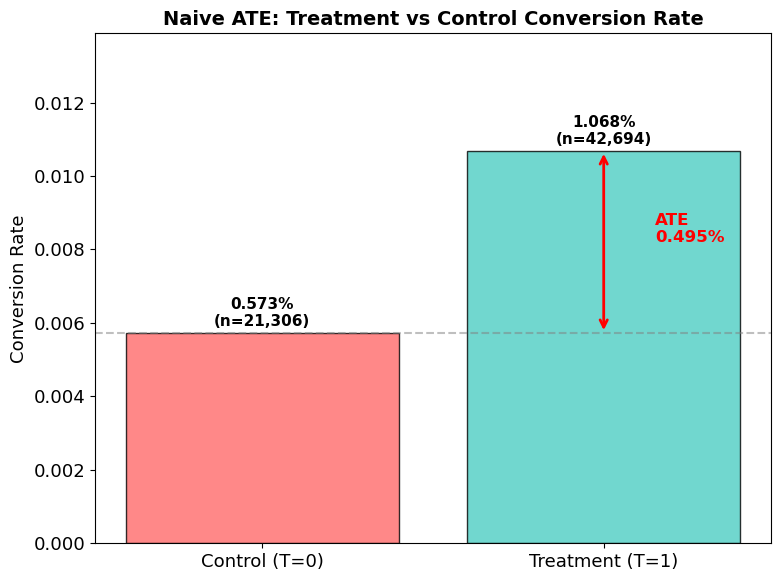

 .png already saved: outputs\figures\fig_01_naive_comparison.png


In [ ]:
# ---------------------------------------------------
# 1.2 Visualize naive ATE comparison
# ---------------------------------------------------

comparison_df = pd.DataFrame({
    'Group': ['Control (T=0)', 'Treatment (T=1)'],
    'Conversion Rate': [conv_rate_control, conv_rate_treated],
    'Sample Size': [len(control), len(treated)]
})

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(
        comparison_df['Group'], 
        comparison_df['Conversion Rate'], 
        color=['#FF6B6B', '#4ECDC4'], 
        alpha=0.8, 
        edgecolor='black'
    )

# Add value labels on bars
for i, (bar, rate, n) in enumerate(zip(bars, comparison_df['Conversion Rate'], comparison_df['Sample Size'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
            f'{rate:.3%}\n(n={n:,})', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add ATE annotation
ax.axhline(conv_rate_control, color='gray', linestyle='--', alpha=0.5)
ax.annotate('', xy=(1, conv_rate_treated), xytext=(1, conv_rate_control),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text(1.15, (conv_rate_treated + conv_rate_control)/2, 
        f'ATE\n{ate_naive_conv:.3%}', fontsize=12, color='red', fontweight='bold')

ax.set_ylabel('Conversion Rate', fontsize=13)
ax.set_title('Naive ATE: Treatment vs Control Conversion Rate', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(comparison_df['Conversion Rate']) * 1.3)
plt.tight_layout()
plt.savefig(figures_dir / 'fig_01_naive_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f" .png already saved: {figures_dir / 'fig_01_naive_comparison.png'}")


Sector 1 summary:
- **Treatment/Control Comparison**: 结果显示朴素 ATE 值为 0.495%, 相对提升达到了非常大的值--- 86.53% 
- **Naive ATE ≠ Causal ATE**: 虽然结果显示朴素 ATE 很大, 但实际上可能是选择误差导致 (比如,如果 `treatement` 组的用户本身消费历史金额 `history` 就更高, 那朴素 ATE 可能只是反映了"富人更爱买东西", 而不是"邮件有效"),即计算得到的朴素 ATE 并不是 因果 ATE,因此后续要做 PSM


## Section 2: Heterogeneous Treatment Exposure